In [424]:
# Importar o componente que retornará informarções de uma ação da bolsa de valores
from yahooquery import Ticker
# Componentes de analise
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import requests
from pandas import json_normalize
import pandas as pd
import math


In [426]:
# Vamos fazer uma analise PETR4 (Petrobrás)
petr = Ticker("PETR4.SA")
petr_dados = petr.history(period="max")
petr_dados.index = petr_dados.index.unique(level='date')
petr_dados.index = pd.to_datetime(petr_dados.index)




In [427]:
petr_dados.head()

,close,open,high,low,volume,adjclose,dividends,splits
date,,,,,,,,
2000-01-03,5.875,5.875,5.875,5.875,3.538944e+10,2.139588,0.0,0.0
2000-01-04,5.550,5.550,5.550,5.550,2.886144e+10,2.021228,0.0,0.0
2000-01-05,5.494,5.494,5.494,5.494,4.303360e+10,2.000834,0.0,0.0
2000-01-06,5.475,5.475,5.475,5.475,3.405568e+10,1.993914,0.0,0.0
2000-01-07,5.500,5.500,5.500,5.500,2.091264e+10,2.003018,0.0,0.0


<AxesSubplot: xlabel='date'>

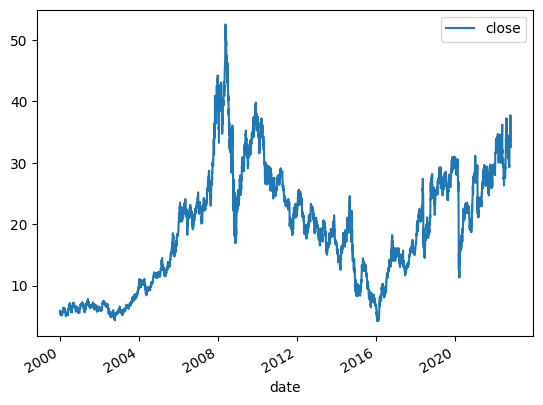

In [428]:
# Verificar a ação desde 2000
petr_dados[["close"]].plot()

<AxesSubplot: xlabel='date'>

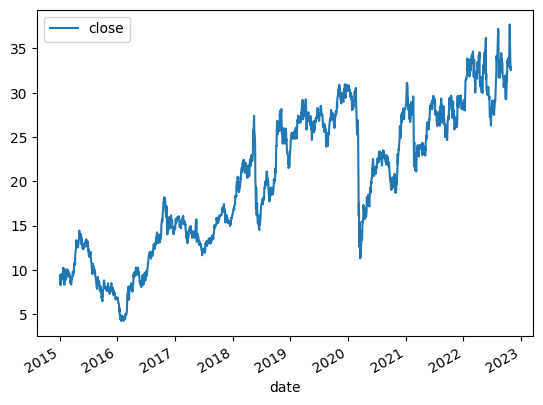

In [429]:
# Verificar a ação a partir 2015
petr_dados[petr_dados.index >= pd.to_datetime('2015-01-01')][["close"]].plot()

<AxesSubplot: xlabel='date'>

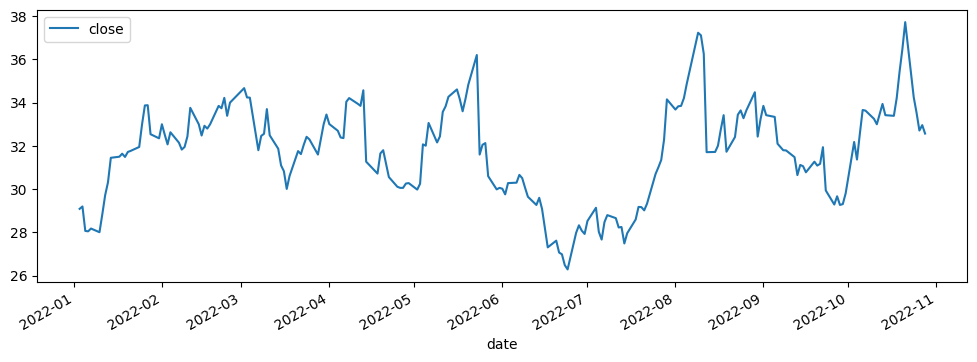

In [430]:
# Verificar a ação esse ano
fig, axs = plt.subplots(figsize=(12, 4))

petr_dados[petr_dados.index >= pd.to_datetime('2022-01-01')][["close"]].plot(ax=axs)

'----'

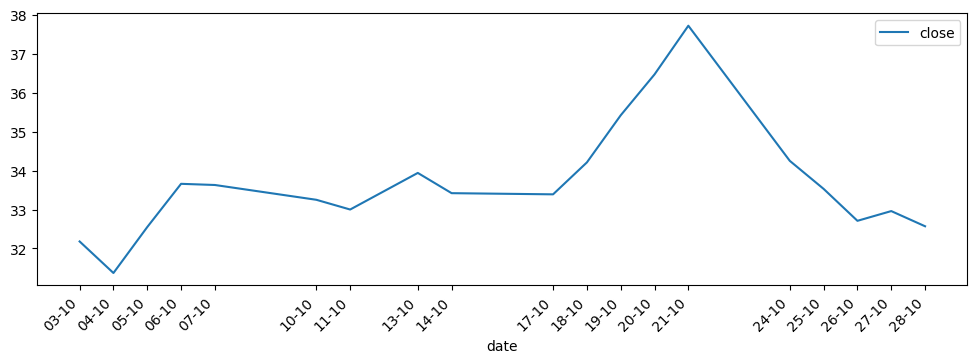

In [431]:
# Verificar o comportamento da ação no ultimo mês

fig, axs = plt.subplots(figsize=(12, 4))
dados_plot = petr_dados[petr_dados.index >= pd.to_datetime((datetime.now() - relativedelta(months=1)))][["close"]]
plot = dados_plot.plot(ax=axs)
x_labels = pd.to_datetime(dados_plot.index).strftime('%d-%m')


plot.set_xticks(dados_plot.index)
plot.set_xticklabels(x_labels, rotation=45)

"----"


In [432]:
# Analisar a base da SELIC

r = requests.get('https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=json')
retorno_api = r.json()

dt_selic = json_normalize(retorno_api) 
dt_selic



,data,valor
0,04/06/1986,0.065041
1,05/06/1986,0.067397
2,06/06/1986,0.066740
3,09/06/1986,0.068247
4,10/06/1986,0.067041
...,...,...
9121,24/10/2022,0.050788
9122,25/10/2022,0.050788
9123,26/10/2022,0.050788
9124,27/10/2022,0.050788


In [433]:
# Transformar o retorno da API em uma série, pra se adaptar ao dataset da ação e para que possamos fazer algumas analises 

def converterDataObj(x):
    return datetime.strptime(x, "%d/%m/%Y")
dt_selic["valor"].index = dt_selic["data"].apply(converterDataObj)
dt_selic["valor"].index.names = ['date']

selic = pd.Series(dt_selic["valor"])
#Converter valores pra float

selic = pd.to_numeric(selic)
selic

date
1986-06-04    0.065041
1986-06-05    0.067397
1986-06-06    0.066740
1986-06-09    0.068247
1986-06-10    0.067041
                ...   
2022-10-24    0.050788
2022-10-25    0.050788
2022-10-26    0.050788
2022-10-27    0.050788
2022-10-28    0.050788
Name: valor, Length: 9126, dtype: float64

In [434]:
# Filtrar para apenas nos anos 2000 pra cima, pois é onde se inicia nosso dataset

selic = selic[selic.index >= pd.to_datetime('2000-01-01')]

<AxesSubplot: xlabel='date'>

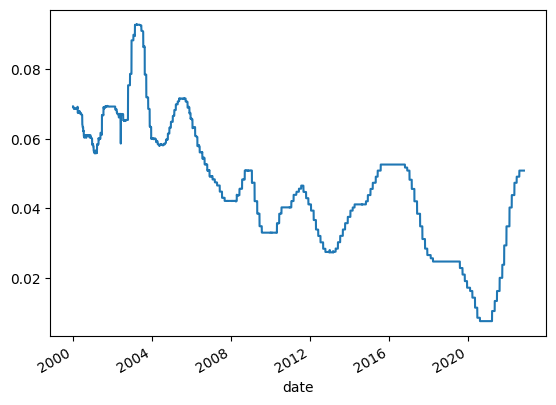

In [435]:
# Verificar o comportamento da SELIC durante os anos 

selic.plot()

In [436]:
# Unir selic com a base PETR4 

petr_dados = petr_dados.assign(selic = selic)

# Verificar se algum ficou em branco 

petr_dados.isna().sum()


close         0
open          0
high          0
low           0
volume        0
adjclose      0
dividends     0
splits        0
selic        62
dtype: int64

In [437]:
# Os em branco vou preencher com o ultimo valor

def preencherUltimoSelic (x):
     
    global selic     
    days = 1   
   
    while math.isnan(x['selic']):
        atual = pd.to_datetime(x.name - relativedelta(days=days)).strftime('%Y-%m-%d')
        if atual in selic.index :
            x['selic'] = selic.loc[atual]                  
        days += 1
    return x

selic_preenchidos = petr_dados[petr_dados["selic"].isna()].apply(preencherUltimoSelic, axis=1)

# depois que descobri os valores anteriores, vou preenchelos na base final

for index,value in selic_preenchidos.iterrows() :    
    petr_dados["selic"][index] = value['selic']

# por fim verificar se não há mais valores nulos

petr_dados.isna().sum()

close        0
open         0
high         0
low          0
volume       0
adjclose     0
dividends    0
splits       0
selic        0
dtype: int64

In [438]:
# Verificar correlação entre as colunas 

corr = petr_dados.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)


C:\Users\gabri\AppData\Local\Temp\ipykernel_79388\682635969.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,close,open,high,low,volume,adjclose,dividends,splits,selic
close,1.00,1.00,0.99,1.00,-0.18,0.89,0.04,0.01,-0.59
open,1.00,1.00,1.00,1.00,-0.18,0.89,0.04,0.01,-0.59
high,0.99,1.00,1.00,0.99,-0.18,0.89,0.04,0.01,-0.58
low,1.00,1.00,0.99,1.00,-0.18,0.89,0.04,0.01,-0.59
volume,-0.18,-0.18,-0.18,-0.18,1.00,-0.16,-0.00,-0.00,0.16
adjclose,0.89,0.89,0.89,0.89,-0.16,1.00,0.08,0.00,-0.60
dividends,0.04,0.04,0.04,0.04,-0.00,0.08,1.00,-0.00,-0.01
splits,0.01,0.01,0.01,0.01,-0.00,0.00,-0.00,1.00,0.02
selic,-0.59,-0.59,-0.58,-0.59,0.16,-0.60,-0.01,0.02,1.00


In [452]:
# Como a ideia é tentar prever diáriamente o valor fechamento, vou criar 5 colunas 
# com a porcentagem de aumento ou diminuição da ação nos ultimos 5 dias do dia em questão,
# acredito que com isso consigo adicionar, alem do valor do selic consigo adicionar a influencia da queda ou valorizacao
# baseado se no passado ela foi valorizada ou não

menorData = min(petr_dados.index) + relativedelta(days=4)

def preencherPorcentagemAumento (x):     
    global petr_dados     
    if x.name <= menorData:
        x['val1'] = 1
        x['val2'] = 1
        x['val3'] = 1
        x['val4'] = 1
        x['val5'] = 1
        return x
    days = 1   
    
    x['val1'] = False

    while x['val1'] == False:    
        atual = pd.to_datetime(x.name - relativedelta(days=days)).strftime('%Y-%m-%d')
        if atual in petr_dados.index :
            valor_close = petr_dados.loc[atual]['close']            
            x['val1'] =  x['close'] / valor_close
          
        days += 1
    
    x['val2'] = False

    while x['val2'] == False:    
        atual = pd.to_datetime(x.name - relativedelta(days=days)).strftime('%Y-%m-%d')
        if atual in petr_dados.index :
            valor_close2 = petr_dados.loc[atual]['close']            
            x['val2'] =  valor_close / valor_close2
          
        days += 1

    x['val3'] = False

    while x['val3'] == False:    
        atual = pd.to_datetime(x.name - relativedelta(days=days)).strftime('%Y-%m-%d')
        if atual in petr_dados.index :
            valor_close3 = petr_dados.loc[atual]['close']            
            x['val3'] =  valor_close2 / valor_close3
          
        days += 1

    x['val4'] = False

    while x['val4'] == False:    
        atual = pd.to_datetime(x.name - relativedelta(days=days)).strftime('%Y-%m-%d')
        if atual in petr_dados.index :
            valor_close4 = petr_dados.loc[atual]['close']            
            x['val4'] =  valor_close3 / valor_close4
          
        days += 1

    x['val5'] = False

    while x['val5'] == False:    
        atual = pd.to_datetime(x.name - relativedelta(days=days)).strftime('%Y-%m-%d')
        if atual in petr_dados.index :
            valor_close5 = petr_dados.loc[atual]['close']            
            x['val5'] =  valor_close4 / valor_close5
          
        days += 1

    return x

petr_dados.apply(preencherPorcentagemAumento, axis=1)


,close,open,high,low,volume,adjclose,dividends,splits,selic,val1,val2,val3,val4,val5
date,,,,,,,,,,,,,,
2000-01-03,5.875000,5.875000,5.875000,5.875000,3.538944e+10,2.139588,0.0,0.0,0.069186,1.000000,1.000000,1.000000,1.000000,1.000000
2000-01-04,5.550000,5.550000,5.550000,5.550000,2.886144e+10,2.021228,0.0,0.0,0.069186,1.000000,1.000000,1.000000,1.000000,1.000000
2000-01-05,5.494000,5.494000,5.494000,5.494000,4.303360e+10,2.000834,0.0,0.0,0.069220,1.000000,1.000000,1.000000,1.000000,1.000000
2000-01-06,5.475000,5.475000,5.475000,5.475000,3.405568e+10,1.993914,0.0,0.0,0.069286,1.000000,1.000000,1.000000,1.000000,1.000000
2000-01-07,5.500000,5.500000,5.500000,5.500000,2.091264e+10,2.003018,0.0,0.0,0.069286,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-24,34.250000,36.500000,36.820000,34.230000,1.421109e+08,34.250000,0.0,0.0,0.050788,0.908006,1.034275,1.029644,1.035370,1.024558
2022-10-25,33.529999,34.040001,34.500000,33.209999,1.131612e+08,33.529999,0.0,0.0,0.050788,0.978978,0.908006,1.034275,1.029644,1.035370
2022-10-26,32.709999,32.599998,33.529999,31.900000,1.213348e+08,32.709999,0.0,0.0,0.050788,0.975544,0.978978,0.908006,1.034275,1.029644


In [ ]:
# 
selic.plot()

TypeError: no numeric data to plot